## Импорты

In [5]:
import mne
import neurokit2 as nk
import numpy as np
import pandas as pd
import pickle
import sklearn as sk
from sklearn.linear_model import LinearRegression

import os
from __future__ import annotations

import copy
from typing import Self


import pickle
import typing
import mne
import neurokit2 as nk
import pandas as pd

# from helper import MicrostateHelperWrapper as MSHW
# from helper import Folders

In [6]:



class Folders:
    """
    Class for storing the paths to the folders for the data.
    ALL FOLDERS SHOULD END WITH A SLASH
    """
    def __init__(
            self,
            end_folder: str,
            raw_data: str,
            preprocessed_data: str,
            save_data: str,
            statistics: str,
            mhw_objects: str,
            images: str
    ):
        self.end_folder = end_folder
        self.raw_data = raw_data
        self.preprocessed_data = preprocessed_data
        self.save_data = save_data
        self.statistics = statistics
        self.mhw_objects = mhw_objects
        self.images = images


class MicrostateHelperWrapper:
    def __init__(
            self,
            folders: Folders,
            raw: mne.io.Raw,
            raw_filename: str
    ):
        self.raw = raw
        self.raw_filename = raw_filename
        self.folders = folders
        self.sampling_rate = raw.info['sfreq']
        self.ms = None
        self.splitted_ms = None
        self.split_dynamic_statistics = None
        self.split_static_statistics = None

    def load(self) -> Self:
        print("Loading MHW object", self.raw_filename)
        with open(
                self.folders.save_data +
                self.folders.mhw_objects +
                self.folders.end_folder +
                self.raw_filename + '.pkl',
                'rb'
        ) as file:
            return pickle.load(file)

    def save(self) -> Self:
        print("Saving MHW object", self.raw_filename)
        folder = self.folders.save_data + self.folders.mhw_objects + self.folders.end_folder
        if not os.path.exists(folder):
            os.makedirs(folder)
        with open(folder + self.raw_filename + '.pkl', 'wb') as file:
            pickle.dump(self, file)
        return self

    def check_saved(self) -> bool:
        try:
            with open(
                    self.folders.save_data +
                    self.folders.mhw_objects +
                    self.folders.end_folder +
                    self.raw_filename + '.pkl',
                    'rb'
            ) as file:
                return True
        except FileNotFoundError:
            return False

    def split_ms_sequence(
            self,
            start_sample=0,
            end_sample=0,
            start_time=0,
            time_end=0
    ):
        """
        Splits the sequence of a microstates object from a given start_sample to a given end_sample.
        If time_end is set, it will convert the time to samples using the sampling_rate, ignoring passed samples.

        :param start_sample: starting sample of the sequence
        :param end_sample: ending sample of the sequence
        :param start_time: starting time of the sequence
        :param time_end: ending time of the sequence
        :return: Microstates object with the sequence sliced from start to end
        """

        sampling_rate = self.sampling_rate
        ms_copy = self.ms.copy()

        if time_end != 0 and end_sample != 0:
            raise ValueError("Only one of time_end or end_sample should be set")

        if time_end != 0:
            end_sample = int(time_end * sampling_rate)
        if start_time != 0:
            start_sample = int(start_time * sampling_rate)

        ms_copy['Sequence'] = ms_copy['Sequence'][start_sample:end_sample]
        ms_copy['GFP'] = ms_copy['GFP'][start_sample:end_sample]
        return ms_copy

    def apply_basic_switch_threshold(
            self,
            inplace=False,
            threshold=0.02,
    ) -> Self:
        """
        Applies the basic switch threshold algorithm to the microstates sequence.
        Removes "noisy" microstates that are shorter than the threshold.

        :param threshold: threshold for the minimum duration (is seconds) of a microstate
        :param inplace: if True, will apply the changes to the current microstates object
        :return: Microstates object with the basic switch threshold applied
        """

        sampling_rate = self.sampling_rate
        ms_clone = self.ms.copy()

        sequence = ms_clone['Sequence'].copy()
        gfp = ms_clone['GFP']
        threshold_samples = threshold * sampling_rate
        print("Threshold samples", threshold_samples)
        while True:
            while True:
                intervals = []
                candidates = []
                for i in range(len(sequence) - 1):
                    if sequence[i] != sequence[i + 1]:
                        intervals.append((i, (i - intervals[-1][0] if len(intervals) > 0 else i), sequence[i - 1]))
                intervals.append(
                    (len(sequence) - 1, len(sequence) - 1 - intervals[-1][0], sequence[-1], (len(sequence) - 1) / 2048))
                # print(np.array(intervals))
                i = 1
                while i < len(intervals) - 1:
                    if (intervals[i][1] < threshold_samples) and (intervals[i - 1][2] == intervals[i + 1][2]):
                        # length = intervals[i][1] + intervals[i-1][1] + intervals[i+1][1]
                        candidates.append((intervals[i - 1], intervals[i], intervals[i + 1]))
                        i += 2
                    i += 1
                if len(candidates) == 0:
                    break
                for candidate in candidates:
                    start = candidate[0][0]
                    end = candidate[1][0] + 1
                    state = candidate[0][2]
                    # print("Filling candidate", start, end, state)
                    # nk.microstates_plot(ms_clone, epoch = (start-50, end+50))
                    sequence[start:end] = state
                    # ms_clone['Sequence'] = sequence
                    # nk.microstates_plot(ms_clone, epoch = (start-50, end+50))
                # time.sleep(500)
            # ms_clone['Sequence'] = sequence
            # nk.microstates_plot(ms_clone, epoch = (0, int(2048)))
            # print("Second stage candidates")

            # while True:
            intervals = []
            candidates = []
            local_gfp_mean = 0
            for i in range(len(sequence) - 1):
                local_gfp_mean += gfp[i]
                if sequence[i] != sequence[i + 1]:
                    # print("Adding sequence", i, "State", sequence[i], "State", sequence[i+1])
                    length = (i - intervals[-1][0] if len(intervals) > 0 else i)
                    if length == 0:
                        length = 1
                    state = sequence[i - 1]
                    local_gfp_mean /= length
                    intervals.append((i, length, state, local_gfp_mean))
                    local_gfp_mean = 0
            intervals.append((len(sequence) - 1, len(sequence) - 1 - intervals[-1][0], sequence[-1], 0))
            # print(intervals)
            i = 1
            while i < len(intervals) - 1:
                # print("Checking interval", intervals[i], threshold_samples)
                if intervals[i][1] < threshold_samples:
                    # gfp_diff_l = intervals[i][3] - intervals[i-1][3]
                    # gfp_diff_r = intervals[i][3] - intervals[i+1][3]
                    # print("GFP diff", gfp_diff_l, gfp_diff_r)
                    ln_diff_l = (intervals[i][1] - intervals[i - 1][1])
                    ln_diff_r = intervals[i][1] - intervals[i + 1][1]
                    if ln_diff_l > 0 and ln_diff_r > 0:
                        i += 1
                        continue

                    # gfp_diff_l = intervals[i][3] - intervals[i-1][3]
                    # gfp_diff_r = intervals[i][3] - intervals[i+1][3]

                    # print("LN diff", ln_diff_l, ln_diff_r, intervals[i][1])

                    # if gfp_diff_l > gfp_diff_r:
                    if ln_diff_l < ln_diff_r:
                        candidates.append((intervals[i - 1], intervals[i], intervals[i - 1][2]))
                    else:
                        candidates.append((intervals[i - 1], intervals[i], intervals[i + 1][2]))
                    i += 2
                i += 1
            if len(candidates) == 0:
                break
            # start_min = 10000000
            # end_max = 0
            for candidate in candidates:
                start = candidate[0][0]
                # if start < start_min:
                #     start_min = start
                end = candidate[1][0] + 1
                # if end > end_max:
                #     end_max = end
                state = candidate[2]
                # print("Filling candidate", start, end, state)
                # nk.microstates_plot(ms_clone, epoch = (start-40, end+40))
                sequence[start:end] = state
                # ms_clone['Sequence'] = sequence
                # nk.microstates_plot(ms_clone, epoch = (start-40, end+40))
                # print('------')
        # print(sequence[:100])
        ms_clone['Sequence'] = sequence

        print("Applied basic switch threshold")

        if inplace:
            self.ms = ms_clone
            return self
        else:
            full_copy = copy.deepcopy(self)
            full_copy.ms = ms_clone
            return full_copy

    def get_event_bounds_by_event_transitions(
            self,
            key_names,
            key_namings,
            transitions,
            time_threshold=20,
    ):
        """
        Extracts event bounds from the raw data annotations using the event transitions.
        :param key_names: annotation names of the events to look for
        :param key_namings: annotation names mapped to event meaning
        :param transitions: event transitions to look for in format [[from_event_name, [to_event_names]]]
        :param time_threshold: minimum duration of the event in seconds
        :return:
            (timestamps - [[start_sample, end_sample]],
            events - [event_meaning_name],
            event_names - {annotation_number: event_meaning_name})

        """

        raw = self.raw
        sampling_rate = self.sampling_rate

        def check_event_name(pair, key_names):
            print(pair)
            key, value = pair
            for key_name in key_names:
                if key_name in key:
                    return True
            return False

        raw_events = mne.events_from_annotations(raw)
        event_sequence = list(map(lambda x: [x[0], x[2]], raw_events[0]))
        event_namemap = dict(filter(lambda x: check_event_name(x, key_names), raw_events[1].items()))
        event_numbers = list(event_namemap.values())
        threshold_samples = time_threshold * sampling_rate

        def get_event_number(event_name, _ev_namemap):
            return list(filter(lambda val: event_name in val[0], _ev_namemap.items()))[0]

        def remap_transitions_to_numbers(trans, ev_namemap):
            remapped_transitions = []
            for transition in trans:
                remapped_transitions.append(
                    [get_event_number(transition[0], ev_namemap)[1],
                     list(map(lambda x: get_event_number(x, ev_namemap)[1], transition[1]))]
                )
            return remapped_transitions

        transition_numbers = remap_transitions_to_numbers(transitions, event_namemap)
        filtered_sequence = list(filter(lambda x: x[1] in event_numbers, event_sequence))
        timestamps = []
        events = []
        for idx in range(len(filtered_sequence)):
            event = filtered_sequence[idx]
            next_event = filtered_sequence[idx + 1] if idx + 1 < len(filtered_sequence) else None
            # print("Idx", idx, "Event", event, "Next event", next_event)
            if next_event is None:
                break
            for transition in transition_numbers:
                if (event[1] == transition[0]) and (next_event[1] in transition[1]):
                    if threshold_samples > next_event[0] - event[0]:
                        print("Event too short, skipping", next_event[0] - event[0], event, next_event)
                        break
                    timestamps.append([event[0], next_event[0]])
                    events.append(event[1])
                    break
        event_names = dict(map(lambda x: (get_event_number(x[0], event_namemap)[1], x[1]), key_namings.items()))
        return timestamps, events, event_names

    def split_ms_sequence_by_events(
            self,
            key_names,
            key_namings,
            transitions,
            time_threshold=20,
            recalc=False
    ) -> Self:
        """
        Splits the microstates sequence by the events in the raw data annotation. Sets in the splitted_ms attribute.

        splitted_ms attribute =
            (timestamps - [[start_sample, end_sample]],
            events - [event_meaning_name],
            event_names - {annotation_number: event_meaning_name})

        :param key_names: annotation names of the events to look for
        :param key_namings: annotation names mapped to event meaning
        :param transitions: event transitions to look for in format [[from_event_name, [to_event_names]]]
        :param time_threshold: minimum duration of the event in seconds
        :param recalc: if True, will recalculate the split
        :return: self
        """

        if self.splitted_ms is not None and not recalc:
            print('Already calculated microstates split')
            return self
        print('Calculating microstates split...')

        timestamps, events, event_names = self.get_event_bounds_by_event_transitions(
            key_names,
            key_namings,
            transitions,
            time_threshold=time_threshold
        )
        sequences = []

        for i in range(len(timestamps)):
            ms_copy = self.split_ms_sequence(start_sample=timestamps[i][0], end_sample=timestamps[i][1])
            sequences.append(ms_copy)

        self.splitted_ms = (sequences, events, event_names, timestamps)

        print("Splitted by events")
        return self

    # TODO: params for the microstates_segment
    def calc_raw_ms(
            self,
            recalc=False
    ) -> Self:
        """
        Calculates the microstates of the raw data. Sets the ms attribute. If recalc is False, will return the current
        :param recalc: if True, will recalculate the microstates
        :return: self
        """
        if self.ms is not None and not recalc:
            print('Already calculated microstates')
            return self

        print('Calculating microstates...')
        microstates = nk.microstates_segment(
            self.raw,
            n_microstates=4,
            method='kmod',
            random_state=42,
            optimize=True
        )
        self.ms = microstates

        return self

    def split_dynamic_calc_statistics(
            self,
            recalc=False
    ) -> Self:

        if self.split_dynamic_statistics is not None and not recalc:
            print('Already calculated dynamic statistics')
            return self

        ms_sequences, events, event_names, timestamps = self.splitted_ms
        dynamic = pd.DataFrame()

        for i in range(len(ms_sequences)):
            print("Event: ", event_names[events[i]])
            duration = (timestamps[i][1] - timestamps[i][0])
            # nk.microstates_plot(ms_sequences[i], epoch = (0, duration))
            # nk.microstates_static(ms_sequences[i], sampling_rate=sampling_rate, show=True)
            ms_dynamic = nk.microstates_dynamic(ms_sequences[i], show=False)
            ms_dynamic['Event'] = event_names[events[i]]
            ms_dynamic['Order'] = i
            dynamic = pd.concat([dynamic, ms_dynamic])

        print("Calculated dynamic statistics")
        dynamic.reset_index(drop=True, inplace=True)
        self.split_dynamic_statistics = dynamic
        return self

    def split_dynamic_save_statistics(self) -> Self:
        folder = self.folders.save_data + self.folders.statistics + self.folders.end_folder
        if not os.path.exists(folder):
            os.makedirs(folder)
        self.split_dynamic_statistics.to_csv(folder + self.raw_filename + '_split_dynamic_stats.csv', index=False)
        print("Saved dynamic statistics")
        return self

    def split_dynamic_drop_self_to_self(self) -> Self:
        for i in range(4):
            # print(f'Microstate_{i}_to_{i}')
            if f'Microstate_{i}_to_{i}' in self.split_dynamic_statistics.columns:
                self.split_dynamic_statistics.drop(f'Microstate_{i}_to_{i}', axis=1, inplace=True)
            else:
                print(f'Microstate_{i}_to_{i} not found or already dropped')
        print("Dropped self-to-self transitions")
        return self

    def split_static_calc_statistics(
            self,
            recalc=False
    ) -> Self:

        try:
            if self.split_static_statistics is not None and not recalc:
                print('Already calculated static statistics')
                return self
        except AttributeError:
            self.split_static_statistics = None

        ms_sequences, events, event_names, timestamps = self.splitted_ms
        static = pd.DataFrame()

        for i in range(len(ms_sequences)):
            print("Event: ", event_names[events[i]])
            duration = (timestamps[i][1] - timestamps[i][0])
            # nk.microstates_plot(ms_sequences[i], epoch = (0, duration))
            ms_static = nk.microstates_static(ms_sequences[i], sampling_rate=self.sampling_rate, show=False)
            ms_static['Event'] = event_names[events[i]]
            ms_static['Order'] = i
            static = pd.concat([static, ms_static])

        print("Calculated static statistics")
        static.reset_index(drop=True, inplace=True)
        self.split_static_statistics = static
        return self

    def split_static_save_statistics(self) -> Self:
        folder = self.folders.save_data + self.folders.statistics + self.folders.end_folder
        if not os.path.exists(folder):
            os.makedirs(folder)
        self.split_static_statistics.to_csv(folder + self.raw_filename + '_split_static_stats.csv', index=False, index_label=False)
        print("Saved static statistics")
        return self


## Константы

In [7]:
# sampling_rate = 2048

raw_data_folder_path = "./raw_data/"
preprocessed_data_folder_path = "./preprocessed_data/"
save_data_folder_path = "./save_data/"
images_folder_path = "./images/"
statistics_folder_path = "statistics/"
mhw_objects_folder_path = "mhw_objects/"

folders = Folders(
    end_folder = "",
    raw_data = raw_data_folder_path,
    preprocessed_data = preprocessed_data_folder_path,
    save_data = save_data_folder_path,
    images = images_folder_path,
    statistics=statistics_folder_path,
    mhw_objects=mhw_objects_folder_path
)


filenames014 = [
    "ACP_INP0014_REST1_1pnt_1vis",
    "ACP_INP0014_REST2_1pnt_1vis",
    "ACP_INP0014_REST3_1pnt_1vis",
    "ACP_INP0014_REST1_1pnt_2vis",
    "ACP_INP0014_REST2_1pnt_2vis",
    "ACP_INP0014_REST3_1pnt_2vis"
]
path014 = "rest_14/"

filenames019 = [
    "INP0019_v1.4_REST1_R003_R003_08.11.23",
    "INP0019_v1.4_REST2_R003_R003_08.11.23",
    "INP0019_v1.4_REST3_R003_R003_08.11.23",
    "INP0019_v1.5_REST2_Op005_Op007_08.12.23",
    "INP0019_v1.5_REST3_Op005_Op007_08.12.23",
]
path019 = "rest_19/"

filenames036 = [
    "INP0036_v1.4_REST1_Op008_Op011_11.12.23",
    "INP0036_v1.4_REST2_Op008_Op011_11.12.23",
    "INP0036_v1.4_REST3_Op008_Op011_11.12.23",
    "INP0036_v1.5_REST1_Op005_Op010_12.12.23",
    "INP0036_v1.5_REST2_Op005_Op010_12.12.23",
    "INP0036_v1.5_REST3_Op005_Op010_12.12.23",
]
path036 = "rest_36/"

filenames045 = [
    "INP0045_v1.4_REST1_R003_R003_08.11.23",
    "INP0045_v1.4_REST2_R003_R003_08.11.23",
    "INP0045_v1.4_REST3_R003_R003_08.11.23",
    "INP0045_v1.5_rs11_Op005_Op008_Op011_17.11.23",
    "INP0045_v1.5_rs22_Op005_Op008_Op011_17.11.23",
    "INP0045_v1.5_rs23_Op005_Op008_Op011_17.11.23",
]
path045 = "rest_45/"

filenames064 = [
    "INP0064_v1.4_rs11_S008_R003_04.12.23",
    "INP0064_v1.4_rs12_Op008_R003_04.12.23",
    "INP0064_v1.4_rs13_Op008_R003_04.12.23",
    "INP0064_v1.5_rs21_Op005_Op006_Op008_05.12.23",
    "INP0064_v1.5_rs22_Op009_A002_13.12.23",
    "INP0064_v1.5_rs23_Op009_A002_13.12.23",
]
path064 = "rest_64/"

# MICROSTATES

## Calculation of mean vals

In [8]:
filename = filenames014[0]
filepath = path014
folders.end_folder = filepath

In [9]:
raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')

C:\Users\bortn\AppData\Local\Temp\ipykernel_18016\1688923764.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')
C:\Users\bortn\AppData\Local\Temp\ipykernel_18016\1688923764.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')


In [10]:
mshw = MicrostateHelperWrapper(
    raw = raw,
    raw_filename = filename,
    folders = folders
)
mshwt = MicrostateHelperWrapper(
    raw = raw,
    raw_filename = filename+'_th',
    folders = folders
)
if mshwt.check_saved():
    mshwt = mshwt.load()
else:
    if mshw.check_saved():
        mshw = mshw.load()
    else:
        mshw.calc_raw_ms()
    mshwt = mshw.apply_basic_switch_threshold(threshold=0.02, inplace=False)
    mshwt.raw_filename = filename+'_th'
    mshwt.save()

Loading MHW object ACP_INP0014_REST1_1pnt_1vis_th


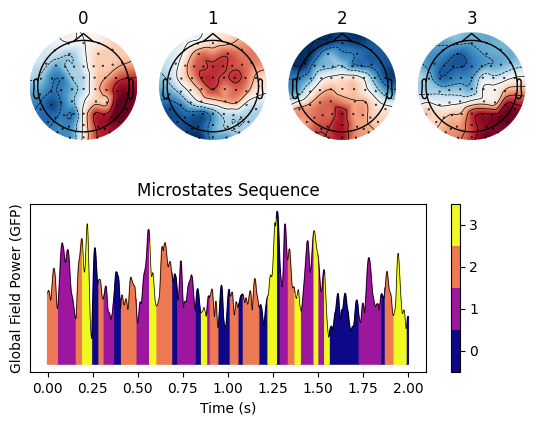

In [11]:
nk.microstates_plot(mshwt.ms, epoch = (0, 2048*2))

In [47]:
# print(mshwt.ms['Sequence'], mshwt.ms['Microstates'])

In [48]:
# nk.microstates_plot(mshwt.ms, epoch = (0, 2048*2))
out2 = nk.microstates_classify(mshwt.ms["Sequence"], mshwt.ms["Microstates"])

In [49]:
ms = mshwt.ms.copy()
ms['Sequence'] = out2[0]
ms['Microstates'] = out2[1]

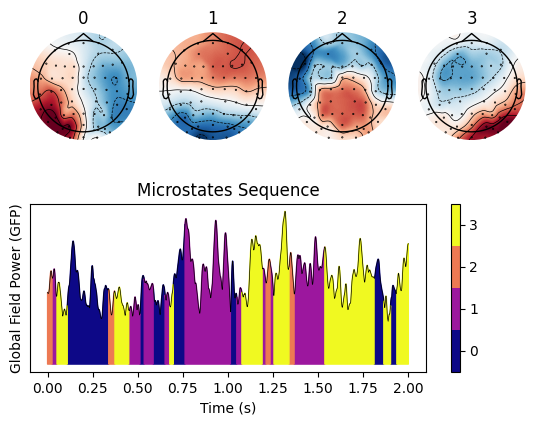

In [50]:
nk.microstates_plot(ms, epoch = (0, 2048*2))

In [102]:
# nk.microstates_plot(mshw.ms, epoch = (0, 2048*2))
# nk.microstates_plot(mshwt.ms, epoch = (0, 2048*2))
# nk.microstates_static(mshw.ms, show=True)
# nk.microstates_static(mshwt.ms, show=True)

In [103]:
transitions = [['s11', ['s2', 's3', 's4']], ['s4', ['s2', 's3', 's11']]]
# transitions = [['s11', ['s2', 's3']], ['s12', ['s2', 's3']]] # 14 - d1
# transitions = [['s11', ['s3']], ['s12', ['s3']]] 

key_names = ['s11', 's2', 's3', 's4']
# key_names = ['s11', 's12', 's2', 's3'] # 14 - d1
# key_names = ['s11', 's12', 's3', 's1'] # 14 - d1

key_namings = {'s11': "Closed", 's4': "Opened"}
# key_namings = {'s11': "Closed", 's12': "Opened"}

timestamps, events, event_names = mshw.get_event_bounds_by_event_transitions(key_names, key_namings, transitions)

print("Timestamps", timestamps)
print("Events", events)
print("Event names", event_names)

if len(events) < 10:
    raise ArithmeticError("Not enough events")


Used Annotations descriptions: ['Impedance', 'boundary', 's11', 's12', 's2', 's3', 's4']
('Impedance', 1)
('boundary', 2)
('s11', 3)
('s12', 4)
('s2', 5)
('s3', 6)
('s4', 7)
Event too short, skipping 0 [1203, 3] [1203, 7]
Event too short, skipping 24 [1203, 7] [1227, 3]
Event too short, skipping 0 [132403, 3] [132403, 7]
Event too short, skipping 2 [132427, 7] [132429, 3]
Event too short, skipping 0 [263605, 3] [263605, 7]
Event too short, skipping 23 [263605, 7] [263628, 3]
Event too short, skipping 0 [394805, 3] [394805, 7]
Event too short, skipping 2 [394828, 7] [394830, 3]
Event too short, skipping 0 [525971, 3] [525971, 7]
Event too short, skipping 2 [525994, 7] [525996, 3]
Timestamps [[1227, 62671], [66827, 128269], [132429, 193869], [198028, 259470], [263628, 325070], [329228, 390669], [394830, 456270], [460394, 521836], [525996, 587436], [591573, 653038]]
Events [3, 7, 3, 7, 3, 7, 3, 7, 3, 7]
Event names {3: 'Closed', 7: 'Opened'}


In [104]:
# mshw.split_ms_sequence_by_events(
#     key_names = key_names,
#     key_namings = key_namings,
#     transitions = transitions
# )
(mshwt
    .split_ms_sequence_by_events(
        key_names = key_names,
        key_namings = key_namings,
        transitions = transitions
    )
    .split_dynamic_calc_statistics()
    .split_dynamic_drop_self_to_self()
    .split_dynamic_save_statistics()
    .split_static_calc_statistics()
    .split_static_save_statistics()
    .save()
 )

Calculating microstates split...
Used Annotations descriptions: ['Impedance', 'boundary', 's11', 's12', 's2', 's3', 's4']
('Impedance', 1)
('boundary', 2)
('s11', 3)
('s12', 4)
('s2', 5)
('s3', 6)
('s4', 7)
Event too short, skipping 0 [1203, 3] [1203, 7]
Event too short, skipping 24 [1203, 7] [1227, 3]
Event too short, skipping 0 [132403, 3] [132403, 7]
Event too short, skipping 2 [132427, 7] [132429, 3]
Event too short, skipping 0 [263605, 3] [263605, 7]
Event too short, skipping 23 [263605, 7] [263628, 3]
Event too short, skipping 0 [394805, 3] [394805, 7]
Event too short, skipping 2 [394828, 7] [394830, 3]
Event too short, skipping 0 [525971, 3] [525971, 7]
Event too short, skipping 2 [525994, 7] [525996, 3]
Splitted by events
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Calculated dynamic statistics
Dropped self-to-self transitions
Saved dynamic statistics
Event:  Closed
Event: 

# FOR ALL FILES IN ONE DATASET

In [167]:
processed = []

In [190]:
exclude_from_event_check = [
    "INP0019_v1.5_REST3_Op005_Op007_08.12.23",
    "INP0036_v1.5_REST1_Op005_Op010_12.12.23",
    "INP0064_v1.5_rs22_Op009_A002_13.12.23",
    "INP0064_v1.5_rs23_Op009_A002_13.12.23"
]

In [191]:
filenames = filenames064
filepath = path064
folders.end_folder = filepath
for filename in filenames:
    if filename in processed:
        continue
    raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')
    mshw = MicrostateHelperWrapper(
        raw = raw,
        raw_filename = filename,
        folders = folders
    )
    mshwt = MicrostateHelperWrapper(
        raw = raw,
        raw_filename = filename+'_th',
        folders = folders
    )
    if mshwt.check_saved():
        mshwt = mshwt.load()
    else:
        if mshw.check_saved():
            mshw = mshw.load()
        else:
            mshw.calc_raw_ms()
        mshwt = mshw.apply_basic_switch_threshold(threshold=0.02, inplace=False)
        mshwt.raw_filename = filename+'_th'
        mshwt.save()
        
    transitions = [['s11', ['s2', 's3', 's4']], ['s4', ['s2', 's3', 's11']]]
    #transitions = [['s11', ['s2', 's3']], ['s12', ['s2', 's3']]] # 14 - d1
    # transitions = [['s11', ['s3']], ['s12', ['s3']]]
    
    key_names = ['s11', 's2', 's3', 's4']
    # key_names = ['s11', 's12', 's2', 's3'] # 14 - d1
    # key_names = ['s11', 's12', 's3', 's1'] # 14 - d1
    
    key_namings = {'s11': "Closed", 's4': "Opened"}
    # key_namings = {'s11': "Closed", 's12': "Opened"}
    
    timestamps, events, event_names = mshw.get_event_bounds_by_event_transitions(key_names, key_namings, transitions)
    print("Timestamps", timestamps)
    print("Events", events)
    print("Event names", event_names)
    print("File length", len(mshwt.ms['Sequence']) / mshwt.sampling_rate, "seconds", len(mshwt.ms['Sequence']), "samples")
    if (len(events) < 10) and (filename not in exclude_from_event_check):
        raise ArithmeticError("Not enough events")
    (mshwt
        .split_ms_sequence_by_events(
            key_names = key_names,
            key_namings = key_namings,
            transitions = transitions
        )
        .split_dynamic_calc_statistics()
        .split_dynamic_drop_self_to_self()
        .split_dynamic_save_statistics()
        .split_static_calc_statistics()
        .split_static_save_statistics()
        .save()
    )
    mean = mshwt.split_static_statistics.groupby('Event').mean()
    #bar
    print('+++STATS+++')
    ld = mean[filter(lambda x: '_LifetimeDistribution' in x, mshwt.split_static_statistics.columns)]
    print(ld.loc['Opened'] - ld.loc['Closed'])
    print('++++++++++++')
    print('Done', filename)
    print('------------------------------')
    processed.append(filename)

/var/folders/tt/nr_wg20d5q13z6kxlpj2xsyc0000gn/T/ipykernel_51565/2996413270.py:7: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')


Loading MHW object INP0064_v1.5_rs23_Op009_A002_13.12.23_th
Used Annotations descriptions: ['Impedance', 'boundary', 's1', 's11', 's12', 's3', 's4']
('Impedance', 1)
('boundary', 2)
('s1', 3)
('s11', 4)
('s12', 5)
('s3', 6)
('s4', 7)
Timestamps [[90695, 152141], [156295, 217739], [221896, 283340], [287475, 348940], [353096, 414539], [418675, 480139], [484297, 545741], [549895, 611340], [615497, 676938]]
Events [4, 5, 4, 5, 4, 5, 4, 5, 4]
Event names {4: 'Closed', 5: 'Opened'}
File length 330.98974609375 seconds 677867 samples
Calculating microstates split...
Used Annotations descriptions: ['Impedance', 'boundary', 's1', 's11', 's12', 's3', 's4']


/var/folders/tt/nr_wg20d5q13z6kxlpj2xsyc0000gn/T/ipykernel_51565/2996413270.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw: mne.io.Raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')


('Impedance', 1)
('boundary', 2)
('s1', 3)
('s11', 4)
('s12', 5)
('s3', 6)
('s4', 7)
Splitted by events
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Calculated dynamic statistics
Dropped self-to-self transitions
Saved dynamic statistics
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Event:  Opened
Event:  Closed
Calculated static statistics
Saved static statistics
Saving MHW object INP0064_v1.5_rs23_Op009_A002_13.12.23_th
+++STATS+++
Microstate_0_LifetimeDistribution    23.20
Microstate_1_LifetimeDistribution    -5.65
Microstate_2_LifetimeDistribution   -49.60
Microstate_3_LifetimeDistribution   -18.30
dtype: float64
++++++++++++
Done INP0064_v1.5_rs23_Op009_A002_13.12.23
------------------------------


<Axes: >

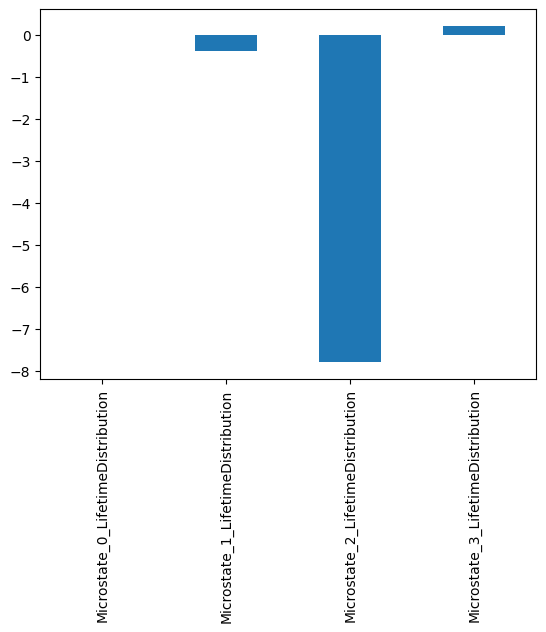

In [161]:
mean = mshwt.split_static_statistics.groupby('Event').mean()
#bar
ld = mean[filter(lambda x: '_LifetimeDistribution' in x, mshwt.split_static_statistics.columns)]
(ld.loc['Opened'] - ld.loc['Closed']).plot(kind='bar')

In [145]:
proportions = mshw.split_static_statistics[filter(lambda x: 'Proportion' in x or 'Event' in x, mshw.split_static_statistics.columns)]
proportions_th = mshwt.split_static_statistics[filter(lambda x: 'Proportion' in x or 'Event' in x, mshw.split_static_statistics.columns)]

<Axes: >

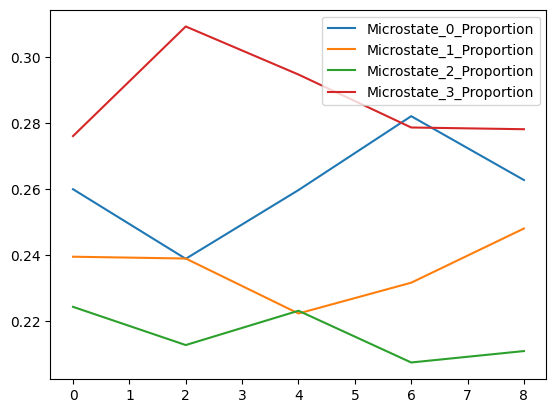

In [146]:
proportions.loc[proportions['Event'] == 'Closed'].plot()

<Axes: >

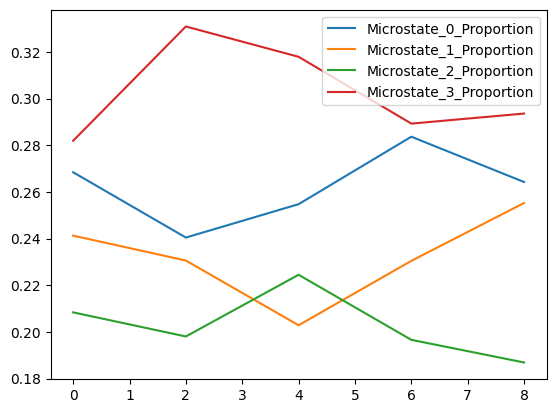

In [147]:
proportions_th.loc[proportions_th['Event'] == 'Closed'].plot()

<Axes: >

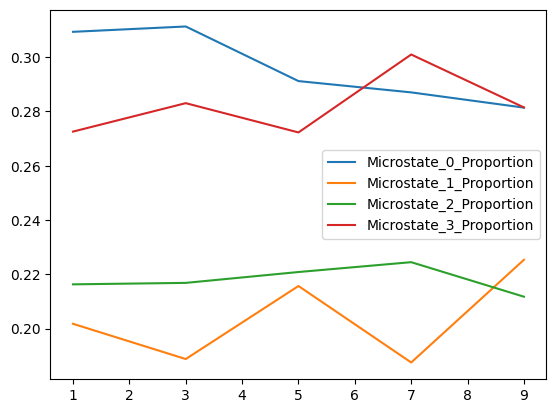

In [132]:
proportions.loc[proportions['Event'] == 'Opened'].plot()

<Axes: >

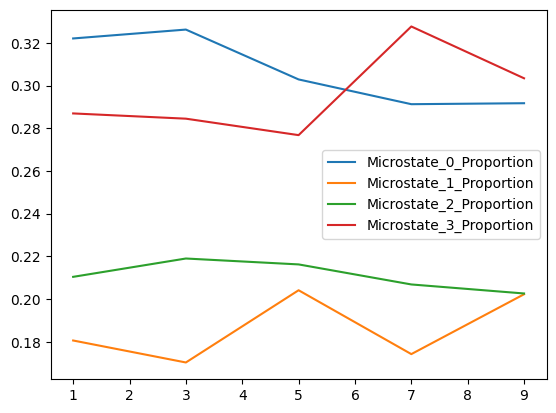

In [133]:
proportions_th.loc[proportions_th['Event'] == 'Opened'].plot()

In [ ]:
def mean_by_event(df):
    clone = df.copy()
    clone.drop('Order', axis=1, inplace=True)
    return clone.groupby('Event').mean()

In [ ]:
mean = mean_by_event(mshw.split_dynamic_statistics)
mean_th = mean_by_event(mshwt.split_dynamic_statistics)

In [ ]:
mean.T.plot()
mean_th.T.plot()
mean.to_csv('./save_data/ms_event_splited_statistics/dynamic/mean/'+filename+'_mean.csv')
mean_th.to_csv('./save_data/ms_event_splited_statistics/dynamic/mean/'+filename+'_th_mean.csv')

In [43]:
mshwt.split_dynamic_statistics

,Microstate_0_to_1,Microstate_0_to_2,Microstate_0_to_3,Microstate_1_to_0,Microstate_1_to_2,Microstate_1_to_3,Microstate_2_to_0,Microstate_2_to_1,Microstate_2_to_3,Microstate_3_to_0,Microstate_3_to_1,Microstate_3_to_2,Event,Order
0,0.002941,0.002740,0.003275,0.003626,0.002702,0.003128,0.002901,0.002611,0.003772,0.002306,0.002842,0.002628,Closed,0
1,0.003497,0.002783,0.002997,0.002691,0.002626,0.003151,0.002922,0.002296,0.003270,0.002634,0.002634,0.002354,Opened,1
2,0.002281,0.002281,0.003612,0.002714,0.002714,0.004072,0.002630,0.002221,0.001987,0.002459,0.003101,0.002352,Closed,2
3,0.001930,0.003475,0.004092,0.002315,0.003367,0.002245,0.002608,0.002490,0.002905,0.002703,0.002646,0.002358,Opened,3
4,0.003218,0.002670,0.003150,0.002468,0.002870,0.002411,0.002401,0.003156,0.003087,0.003701,0.002826,0.002422,Closed,4
5,0.002620,0.002758,0.003378,0.002522,0.002328,0.003104,0.002645,0.002711,0.002380,0.002870,0.002687,0.002565,Opened,5
6,0.002962,0.002962,0.003169,0.002980,0.001965,0.003423,0.002082,0.002545,0.002372,0.002719,0.002497,0.002553,Closed,6
7,0.002762,0.002275,0.004630,0.002128,0.002800,0.002632,0.002502,0.003424,0.002041,0.002669,0.003041,0.002731,Opened,7
8,0.003573,0.002813,0.003497,0.002806,0.002744,0.003243,0.002611,0.002307,0.002854,0.002106,0.002809,0.002357,Closed,8
9,0.003384,0.002901,0.003465,0.002480,0.002949,0.003083,0.002192,0.002862,0.002253,0.002767,0.002146,0.002202,Opened,9


In [122]:
# ms.plot_maps(maps, raw_bv_reconst_reref.info) 
# nk.microstates_plot(microstates, epoch = (0, 2048*10))
# ms.plot_segmentation(segmentation[:2048], raw_bv_reconst_reref.get_data()[:, :2048], raw_bv_reconst_reref.times[:2048])
# nk.microstates_static(microstates, sampling_rate=sampling_rate, show=True)
# nk.microstates_dynamic(microstates, show=True)
# gfp = nk.eeg_gfp(raw_resample)
# 
# peaks = nk.microstates_peaks(raw_resample, gfp=gfp)
# 
# # Plot the peaks in the first 200 data points
# nk.events_plot(events = peaks[peaks < int(2048/2)], signal = gfp[0:int(2048/2)])